# Catalyst classification tutorial

Authors: [Roman Tezikov](https://github.com/TezRomacH), [Sergey Kolesnikov](https://github.com/Scitator)

[![Catalyst logo](https://raw.githubusercontent.com/catalyst-team/catalyst-pics/master/pics/catalyst_logo.png)](https://github.com/catalyst-team/catalyst)

### Colab setup

First of all, do not forget to change the runtime type to GPU. <br/>
To do so click `Runtime` -> `Change runtime type` -> Select `"Python 3"` and `"GPU"` -> click `Save`. <br/>
After that you can click `Runtime` -> `Run` all and watch the tutorial.

## Requirements

Download and install the latest version of catalyst and other libraries required for this tutorial.

In [0]:
# this variable will be used in `runner.train` and by default we disable FP16 mode
is_fp16_used = False

In [2]:
# for augmentations
!pip install albumentations

# for pretrained models for PyTorch
!pip install pretrainedmodels


################
# Catalyst itself
!pip install -U catalyst
# For specific version of catalyst, uncomment:
# ! pip install git+http://github.com/catalyst-team/catalyst.git@{master/commit_hash}
################

# for TTA
# !pip install ttach

# for tensorboard
!pip install tensorflow
%load_ext tensorboard


# if Your machine support Apex FP16, uncomment this 3 lines below
# !git clone https://github.com/NVIDIA/apex
# !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex
# is_fp16_used = True

     |████████████████████████████████| 634kB 3.4MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=77d64fdd6b4bddd649897443b7e177b63db45b3b7d68324710e084de145e9f01
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 61kB 2.4MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=98cc3883baca9663f99418f6da8477594f74660f2abef57ab7a73365fc8c87be
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
     |████████████████████████████████| 327kB 3.4MB/s 
     |████████████████████████████████| 204kB 11.2MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |██

### Colab extras – Plotly

To intergate visualization library `plotly` to colab, run

In [0]:
import IPython

def configure_plotly_browser_state():
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

## Setting up GPUs

In [4]:
from typing import Callable, List, Tuple 

import os
import torch
import catalyst

from catalyst.dl import utils

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

alchemy not available, to install alchemy, run `pip install alchemy-catalyst`.


torch: 1.3.1, catalyst: 20.01.1


-------

## Dataset

As a dataset we will take [Best Artworks of All Time](https://www.kaggle.com/ikarus777/best-artworks-of-all-time) - collection of Paintings of the 50 Most Influential Artists of All Time.

> If you are on MacOS and you don’t have `wget`, you can install it with: `brew install wget`.

After Catalyst installation, `download-gdrive` function become available to download objects from Google Drive.
We use it to download datasets.

usage: `download-gdrive {FILE_ID} {FILENAME}`

In [5]:
%%bash

download-gdrive 1eAk36MEMjKPKL5j9VWLvNTVKk4ube9Ml artworks.tar.gz
extract-archive artworks.tar.gz &>/dev/null

Output hidden; open in https://colab.research.google.com to view.

In [6]:
from pathlib import Path

ROOT = "artworks/"
ALL_IMAGES = list(Path(ROOT).glob("**/*.jpg"))
ALL_IMAGES = list(filter(lambda x: not x.name.startswith("."), ALL_IMAGES))
print("Number of images:", len(ALL_IMAGES))

Number of images: 8446


Let's check out the data!

In [7]:
from catalyst.utils import imread
import numpy as np

import matplotlib.pyplot as plt

def show_examples(images: List[Tuple[str, np.ndarray]]):
    _indexes = [(i, j) for i in range(2) for j in range(2)]
    
    f, ax = plt.subplots(2, 2, figsize=(16, 16))
    for (i, j), (title, img) in zip(_indexes, images):
        ax[i, j].imshow(img)
        ax[i, j].set_title(title)
    f.tight_layout()

def read_random_images(paths: List[Path]) -> List[Tuple[str, np.ndarray]]:
    data = np.random.choice(paths, size=4)
    result = []
    for d in data:
        title = f"{d.parent.name}: {d.name}"
        _image = imread(d)
        result.append((title, _image))
    
    return result

You can restart the cell below to see more examples.

In [8]:
images = read_random_images(ALL_IMAGES)
show_examples(images)

Output hidden; open in https://colab.research.google.com to view.

## Dataset preprocessing

With Catalyst we can easily create a dataset from the following folder structure:
```
dataset/
    class_1/
        *.ext
        ...
    class_2/
        *.ext
        ...
    ...
    class_N/
        *.ext
        ...
```

First of all `create_dataset` function goes through a given directory and creates a dictionary `Dict[class_name, List[image]]`. <br/>
Then `create_dataframe` function creates typical `pandas.DataFrame` for further analysis. <br/>
After than `prepare_dataset_labeling` creates a numerical label for each unique class name. <br/>
Finally, to add a column with a numerical label value to the DataFrame, we can use `map_dataframe` function.

Additionaly let's save the `class_names` for further usage.

In [9]:
from catalyst.utils.dataset import create_dataset, create_dataframe, prepare_dataset_labeling
from catalyst.utils.pandas import map_dataframe

dataset = create_dataset(dirs=f"{ROOT}/*", extension="*.jpg")
df = create_dataframe(dataset, columns=["class", "filepath"])

tag_to_label = prepare_dataset_labeling(df, "class")
class_names = [name for name, id_ in sorted(tag_to_label.items(), key=lambda x: x[1])]

df_with_labels = map_dataframe(
    df, 
    tag_column="class", 
    class_column="label", 
    tag2class=tag_to_label, 
    verbose=False
)
df_with_labels.head()

,class,filepath,label
0,Albrecht_Dürer,artworks/Albrecht_Dürer/Albrecht_Dürer_1.jpg,0
1,Albrecht_Dürer,artworks/Albrecht_Dürer/Albrecht_Dürer_10.jpg,0
2,Albrecht_Dürer,artworks/Albrecht_Dürer/Albrecht_Dürer_100.jpg,0
3,Albrecht_Dürer,artworks/Albrecht_Dürer/Albrecht_Dürer_101.jpg,0
4,Albrecht_Dürer,artworks/Albrecht_Dürer/Albrecht_Dürer_102.jpg,0


In [10]:
tag_to_label

{'Albrecht_Dürer': 0,
 'Alfred_Sisley': 1,
 'Amedeo_Modigliani': 2,
 'Andrei_Rublev': 3,
 'Andy_Warhol': 4,
 'Camille_Pissarro': 5,
 'Caravaggio': 6,
 'Claude_Monet': 7,
 'Diego_Rivera': 8,
 'Diego_Velazquez': 9,
 'Edgar_Degas': 10,
 'Edouard_Manet': 11,
 'Edvard_Munch': 12,
 'El_Greco': 13,
 'Eugene_Delacroix': 14,
 'Francisco_Goya': 15,
 'Frida_Kahlo': 16,
 'Georges_Seurat': 17,
 'Giotto_di_Bondone': 18,
 'Gustav_Klimt': 19,
 'Gustave_Courbet': 20,
 'Henri_Matisse': 21,
 'Henri_Rousseau': 22,
 'Henri_de_Toulouse-Lautrec': 23,
 'Hieronymus_Bosch': 24,
 'Jackson_Pollock': 25,
 'Jan_van_Eyck': 26,
 'Joan_Miro': 27,
 'Kazimir_Malevich': 28,
 'Leonardo_da_Vinci': 29,
 'Marc_Chagall': 30,
 'Michelangelo': 31,
 'Mikhail_Vrubel': 32,
 'Pablo_Picasso': 33,
 'Paul_Cezanne': 34,
 'Paul_Gauguin': 35,
 'Paul_Klee': 36,
 'Peter_Paul_Rubens': 37,
 'Pierre-Auguste_Renoir': 38,
 'Piet_Mondrian': 39,
 'Pieter_Bruegel': 40,
 'Raphael': 41,
 'Rembrandt': 42,
 'Rene_Magritte': 43,
 'Salvador_Dali': 44,


Now let's divide our dataset into the `train` and` valid` parts. <br/>
The parameters for the split_dataframe function are the same as [sklearn.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn-model-selection-train-test-split). <br/>
We also define `test_size` (it is optional) and `random_state` for reproducibility.

In [12]:
from catalyst.utils.dataset import split_dataframe

train_data, valid_data = split_dataframe(df_with_labels, test_size=0.2, random_state=SEED)
train_data, valid_data = train_data.to_dict('records'), valid_data.to_dict('records')

In order to save your time during data preparation/reading/writing, Catalyst provides a special abstraction – [Reader](https://catalyst-team.github.io/catalyst/api/data.html#reader). <br/> 
Reader allows you to read various structures, for example, images, strings, numerical values and perform some functions on top of them.

In [13]:
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose

num_classes = len(tag_to_label)

# ReaderCompose collects different Readers into one pipeline
open_fn = ReaderCompose([
    
    # Reads images from the `datapath` folder 
    # using the key `input_key =" filepath "` (here should be the filename)
    # and writes it to the output dictionary by `output_key="features"` key
    ImageReader(
        input_key="filepath",
        output_key="features",
        datapath=ROOT
    ),
    
    # Reads a number from our dataframe 
    # by the key `input_key =" label "` to np.long
    # and writes it to the output dictionary by `output_key="targets"` key
    ScalarReader(
        input_key="label",
        output_key="targets",
        default_value=-1,
        dtype=np.int64
    ),
    
    # Same as above, but with one encoding
    ScalarReader(
        input_key="label",
        output_key="targets_one_hot",
        default_value=-1,
        dtype=np.int64, 
        one_hot_classes=num_classes
    )
])

-------

## Augmentations

[![Albumentation logo](https://albumentations.readthedocs.io/en/latest/_static/logo.png)](https://github.com/albu/albumentations)

The [albumentation](https://github.com/albu/albumentations) library works with images and masks at the same time, which is what we need.

In [14]:
import albumentations as albu
from albumentations.pytorch import ToTensor

BORDER_CONSTANT = 0
BORDER_REFLECT = 2

def pre_transforms(image_size=224):
    # Convert the image to a square of size image_size x image_size
    # (keeping aspect ratio)
    result = [
        albu.LongestMaxSize(max_size=image_size),
        albu.PadIfNeeded(image_size, image_size, border_mode=BORDER_CONSTANT)
    ]
    
    return result

def hard_transforms():
    result = [
        # Random shifts, stretches and turns with a 50% probability
        albu.ShiftScaleRotate( 
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=15,
            border_mode=BORDER_REFLECT,
            p=0.5
        ),
        albu.IAAPerspective(scale=(0.02, 0.05), p=0.3),
        # Random brightness / contrast with a 30% probability
        albu.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2, p=0.3
        ),
        # Random gamma changes with a 30% probability
        albu.RandomGamma(gamma_limit=(85, 115), p=0.3),
        # Randomly changes the hue, saturation, and color value of the input image
        albu.HueSaturationValue(p=0.3),
        albu.JpegCompression(quality_lower=80),
    ]
    
    return result

def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]

def compose(transforms_to_compose):
    # combine all augmentations into one single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

Like Reader, there is a close abstraction for handling augmentations and key-value-based dataloaders – [Augmentor](https://catalyst-team.github.io/catalyst/api/data.html#augmentor).

In [15]:
from catalyst.data.augmentor import Augmentor


train_transforms = compose([
    pre_transforms(), 
    hard_transforms(), 
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([pre_transforms(), hard_transforms()])

# Takes an image from the input dictionary by the key `dict_key` 
# and performs `train_transforms` on it.
train_data_transforms = Augmentor(
    dict_key="features",
    augment_fn=lambda x: train_transforms(image=x)["image"]
)


# Similarly for the validation part of the dataset. 
# we only perform squaring, normalization and ToTensor
valid_data_transforms = Augmentor(
    dict_key="features",
    augment_fn=lambda x: valid_transforms(image=x)["image"]
)

Let's look at the augmented results. <br/>
You can restart the cell below to see more examples of augmentations.

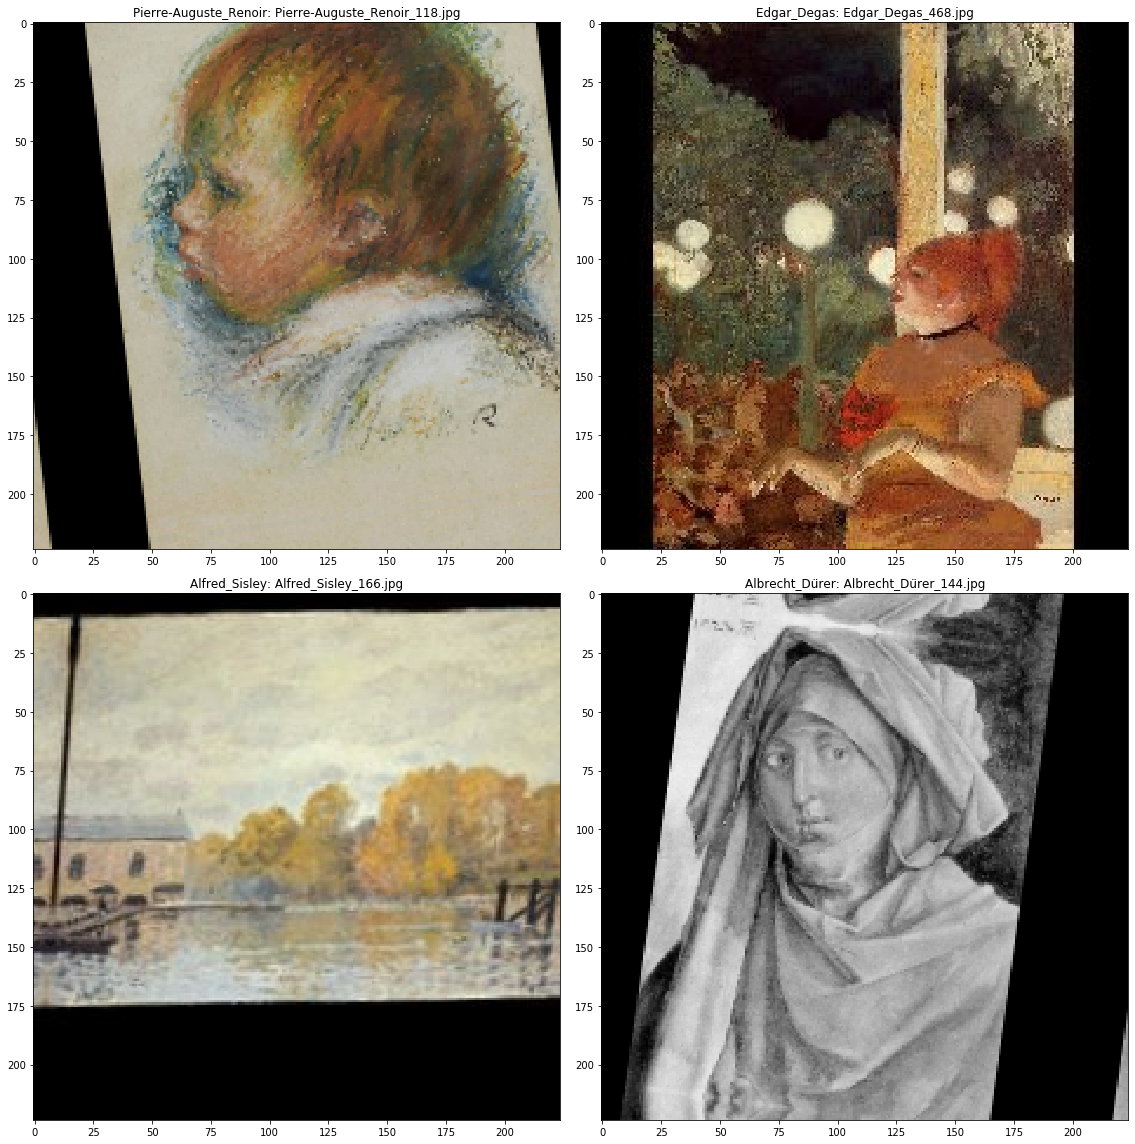

In [16]:
images = read_random_images(ALL_IMAGES)

images = [
    (title, show_transforms(image=i)["image"])
    for (title, i) in images
]
show_examples(images)

-------

## Loaders

Using `catalyst.utils.get_loader`, you can immediately get loaders only from the dataset and data-converting functions.

In [17]:
import collections

def get_loaders(
    open_fn: Callable,
    train_transforms_fn,
    valid_transforms_fn,
    batch_size: int = 64, 
    num_workers: int = 4,
    sampler = None
) -> collections.OrderedDict:
    """
    Args:
        open_fn: Reader for reading data from a dataframe
        train_transforms_fn: Augmentor for train part
        valid_transforms_fn: Augmentor for valid part
        batch_size: batch size
        num_workers: How many subprocesses to use to load data,
        sampler: An object of the torch.utils.data.Sampler class 
            for the dataset data sampling strategy specification
    """
    train_loader = utils.get_loader(
        train_data,
        open_fn=open_fn,
        dict_transform=train_transforms_fn,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=sampler is None, # shuffle data only if Sampler is not specified (PyTorch requirement)
        sampler=sampler,
        drop_last=True,
    )

    valid_loader = utils.get_loader(
        valid_data,
        open_fn=open_fn,
        dict_transform=valid_transforms_fn,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False, 
        sampler=None,
        drop_last=True,
    )

    # Catalyst expects an ordered dictionary with train/valid/infer loaders. 
    # The number of loaders can vary.
    # For example, it can easily handle even some complex logic like:
    # loaders["train_dataset1"] = train_loader_1
    # loaders["train_dataset2"] = train_loader_2
    # ....
    # loaders["valid_1"] = valid_loader_1
    # loaders["valid_2"] = valid_loader_2
    # ...
    # loaders["infer_1"] = infer_loader_1
    # loaders["infer_2"] = infer_loader_2
    # ...
    
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

if is_fp16_used:
    batch_size = 128
else:
    batch_size = 64

print(f"batch_size: {batch_size}")

loaders = get_loaders(
    open_fn=open_fn, 
    train_transforms_fn=train_data_transforms,
    valid_transforms_fn=valid_data_transforms,
    batch_size=batch_size,
)


batch_size: 64


-------

## Experiment
### Model

Let's take the classification model from [Cadene pretrain models](https://github.com/Cadene/pretrained-models.pytorch). This repository contains a huge number of pre-trained PyTorch models.

**> Мы вместо этого используем [EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch)**

In [18]:
!pip install --upgrade efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.1-cp36-none-any.whl size=12407 sha256=e83ef52f21f34f6b516191528d68867d1b6d60501b732f9ea58881aa149cc8d1
  Stored in directory: /root/.cache/pip/wheels/0f/b0/79/1663bc9714b5d88deba05e44f593ce50111bd69305a45df87a
Successfully built efficientnet-pytorch


In [19]:
!pip list

Package                  Version    
------------------------ -----------
absl-py                  0.9.0      
alabaster                0.7.12     
albumentations           0.1.12     
altair                   4.0.0      
asgiref                  3.2.3      
astor                    0.8.1      
astropy                  4.0        
atari-py                 0.2.6      
atomicwrites             1.3.0      
attrs                    19.3.0     
audioread                2.1.8      
autograd                 1.3        
Babel                    2.8.0      
backcall                 0.1.0      
backports.tempfile       1.0        
backports.weakref        1.0.post1  
beautifulsoup4           4.6.3      
bleach                   3.1.0      
blis                     0.2.4      
bokeh                    1.4.0      
boto                     2.49.0     
boto3                    1.10.47    
botocore                 1.13.47    
Bottleneck               1.3.1      
branca                   0.3.1      
b

In [20]:
from torch import nn
#import pretrainedmodels
from efficientnet_pytorch import EfficientNet
#net = EfficientNet.from_pretrained('efficientnet-b4')

def get_model(model_name: str, num_classes: int, pretrained: str = "imagenet"):
    # model_fn = pretrainedmodels.__dict__[model_name]
    # model = model_fn(num_classes=1000, pretrained=pretrained)
    
    model = EfficientNet.from_pretrained(model_name)

    model._fc = nn.Sequential()
    dim_feats = model._fc.in_features
    model.linear_last = nn.Linear(dim_feats, num_classes)

    return model

model_name = 'efficientnet-b4'
model = get_model(model_name, num_classes)
model

NameError: ignored

In [0]:
torch.cuda.empty_cache()

In [0]:
!nvidia-smi

### Model training

In [0]:
import torch

# as we are working on basic classification problem (no multi-class/multi-label)
# let's use standard CE loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[9], gamma=0.3
)

To run some DL experiment, Catalyst uses a [Runner](https://catalyst-team.github.io/catalyst/api/dl.html#catalyst.dl.core.runner.Runner) abstraction. <br/>
It contains main logic about "how" you run the experiment and getting predictions.

For supervised learning case, there is an extention for Runner – [SupervisedRunner](https://catalyst-team.github.io/catalyst/api/dl.html#module-catalyst.dl.runner.supervised), which provides additional methods like `train`, `infer` and `predict_loader`.

In [0]:
from catalyst.dl.runner import SupervisedRunner

num_epochs = 10
logdir = "./logs/classification"

device = utils.get_device()
print(f"device: {device}")

if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

print(f"FP16 params: {fp16_params}")

runner = SupervisedRunner(device=device)

Using [Callbacks](https://catalyst-team.github.io/catalyst/api/dl.html#catalyst.dl.core.callback.Callback), the basic functionality of the catalyst can be expanded.

A callback is a class inherited from `catalyst.dl.core.Callback` and implements one / several / all methods:

```
on_stage_start
    --- on_epoch_start
    ------ on_loader_start
    --------- on_batch_start
    --------- on_batch_end
    ------ on_loader_end
    --- on_epoch_end
on_stage_end

on_exception - if the code crashes with an error, you can catch it and reserve the parameters you need
```

You can find the list of standard callbacks [here](https://catalyst-team.github.io/catalyst/api/dl.html#module-catalyst.dl.callbacks.checkpoint). 
It includes callbacks such as
- CheckpointCallback. Saves N best models in logdir
- TensorboardLogger. Logs all metrics to tensorboard
- EarlyStoppingCallback. Early training stop if metrics do not improve for the `patience` of epochs
- ConfusionMatrixCallback. Plots ConfusionMatrix per epoch in tensorboard

Many different metrics for classfication
- AccuracyCallback
- MapKCallback
- AUCCallback
- F1ScoreCallback

segmentation
- DiceCallback
- IouCallback

and many other callbacks, like LRFinder and MixupCallback

### Monitoring in tensorboard

If you do not have a Tensorboard opened after you have run the cell below, try running the cell again.

In [0]:
%tensorboard --logdir {logdir}

### Running train-loop

In [0]:
# as we are working on classification task
from catalyst.dl.callbacks import AccuracyCallback, AUCCallback, F1ScoreCallback

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    # For this task, we will check accuracy, AUC and F1 metrics
    callbacks=[
        AccuracyCallback(num_classes=num_classes),
        AUCCallback(
            num_classes=num_classes,
            input_key="targets_one_hot",
            class_names=class_names
        ),
        F1ScoreCallback(
            input_key="targets_one_hot",
            activation="Softmax"
        )
    ],
    # path to save logs
    logdir=logdir,
    
    num_epochs=num_epochs,
    
    # save our best checkpoint by AUC metric
    main_metric="auc/_mean",
    # AUC needs to be maximized.
    minimize_metric=False,
    
    # for FP16. It uses the variable from the very first cell
    fp16=fp16_params,
    
    # prints train logs
    verbose=True
)

### Training analysis

The `utils.plot_metrics` method reads tensorboard logs from the logdir and plots beautiful metrics with `plotly` package.

In [0]:
# tensorboard should be enought, uncomment to check plotly version
# it can take a while (colab issue)
# utils.plot_metrics(
#     logdir=logdir, 
#     # specify which metrics we want to plot
#     metrics=["loss", "accuracy01", "auc/_mean", "f1_score", "_base/lr"]
# )

## Model inference

Let's look at model predictions.

In [0]:
from torch.nn.functional import softmax

def show_prediction(
    model: torch.nn.Module, 
    class_names: List[str], 
    titles: List[str],
    images: List[np.ndarray],
    device: torch.device
) -> None:
    with torch.no_grad():
        tensor_ = torch.stack([
            valid_transforms(image=image)["image"]
            for image in images
        ]).to(device)
        
        
        logits = model.forward(tensor_)
        probabilities = softmax(logits, dim=1)
        predictions = probabilities.argmax(dim=1)
    
    images_predicted_classes = [
        (f"predicted: {class_names[x]} | correct: {title}", image)
        for x, title, image in zip(predictions, titles, images)
    ]
    show_examples(images_predicted_classes)


In [0]:
device = utils.get_device()
titles, images = list(zip(*read_random_images(ALL_IMAGES)))
titles = list(map(lambda x: x.rsplit(":")[0], titles))
show_prediction(model, class_names=class_names, titles=titles, images=images, device=device)


Additionally with SupervisedRunner, you can easily predict entire loader with only one method call. <br/>
The resulting object has shape = (number of elements in the loader, output shape from the model)

In [0]:
predictions = runner.predict_loader(
    model, loaders["valid"],
    resume=f"{logdir}/checkpoints/best.pth", verbose=True
)
print(predictions.shape)

print("logits: ", predictions[0])

probabilities = torch.softmax(torch.from_numpy(predictions[0]), dim=0)
print("probabilities: ", probabilities)

label = probabilities.argmax().item()
print(f"predicted: {class_names[label]}")

## Model tracing

Catalyst allows you to use Runner to make [tracing](https://pytorch.org/docs/stable/jit.html) models.

> How to do this in the Config API, we wrote in [our blog (issue \#2)](https://github.com/catalyst-team/catalyst-info#catalyst-info-2-tracing-with-torchjit)

For this purpose it is necessary to pass in a method `trace ` model and a batch on which `predict_batch ` will be executed:

In [0]:
batch = next(iter(loaders["valid"]))
# saves to `logdir` and returns a `ScriptModule` class
runner.trace(model=model, batch=batch, logdir=logdir, fp16=is_fp16_used)

!ls {logdir}/trace/

After this, you can easily load the model and predict anything!

In [0]:
if is_fp16_used:
    model = utils.load_traced_model(f"{logdir}/trace/traced-forward-opt_O1.pth", device="cuda", opt_level="O1")
else:
    model = utils.load_traced_model(f"{logdir}/trace/traced-forward.pth", device="cpu")

In [0]:
model_input = batch["features"].to("cuda" if is_fp16_used else "cpu")
model.forward(model_input)

### Advanced: Custom Callbacks

Let's count the number of predicted labels per class.

In [0]:
import collections

from catalyst.dl import Callback, CallbackOrder, RunnerState


class CustomInferCallback(Callback):
  def __init__(self):
    super().__init__(CallbackOrder.Internal)
    self.class_counts = collections.defaultdict(lambda: 0)

  def on_loader_start(self, state: RunnerState):
    self.class_counts = collections.defaultdict(lambda: 0)

  def on_batch_end(self, state: RunnerState):
    # data from the Dataloader
    # features, targets = state.input["features"], state.input["targets"]
    logits = state.output["logits"]

    labels = logits.argmax(axis=1)
    labels = labels.cpu().detach().numpy().tolist()
    for label in labels:
        self.class_counts[label] += 1


In [0]:
from collections import OrderedDict
from catalyst.dl.callbacks import CheckpointCallback

infer_loaders = {"infer": loaders["valid"]}
model = get_model(model_name, num_classes)

device = utils.get_device()
if is_fp16_used:
    fp16_params = dict(opt_level="O1") # params for FP16
else:
    fp16_params = None

runner = SupervisedRunner(device=device)
runner.infer(
    model=model,
    loaders=infer_loaders,
    callbacks=OrderedDict([
        ("loader", CheckpointCallback(resume=f"{logdir}/checkpoints/best.pth")),
        ("infer", CustomInferCallback())
    ]),
    fp16=fp16_params,
)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

class_counts = runner.callbacks["infer"].class_counts
counts = [class_counts[x] for x in range(len(class_names))]

plt.figure(figsize=(20, 9))
x = np.arange(len(counts))
plt.bar(x + 0.5, height=counts)
plt.xticks(x - 0.3, class_names, rotation=65)
plt.show()

### Advanced: Training with Focal Loss and OneCycle

In the `catalyst.contrib` there are a large number of different additional criterions, models, layers etc

For example,

[catalyst.contrib.criterion](https://catalyst-team.github.io/catalyst/api/contrib.html#module-catalyst.contrib.criterion.ce):
- HuberLoss
- CenterLoss
- FocalLossMultiClass
- DiceLoss / BCEDiceLoss
- IoULoss / BCEIoULoss
- LovaszLossBinary / LovaszLossMultiClass / LovaszLossMultiLabel
- WingLoss

Lr scheduler in [catalyst.contrib.schedulers](https://catalyst-team.github.io/catalyst/api/contrib.html#module-catalyst.contrib.schedulers.base):
- OneCycleLRWithWarmup

Moreover, in [catalyst.contrib.models](https://catalyst-team.github.io/catalyst/api/contrib.html#models) you can find various models for segmentation:
- Unet / ResnetUnet
- Linknet / ResnetLinknet
- FPNUnet / ResnetFPNUnet
- PSPnet / ResnetPSPnet
- MobileUnet


Finally, several handwritten modules in [catalyst.contrib.modules](https://catalyst-team.github.io/catalyst/api/contrib.html#module-catalyst.contrib.modules.common):
- Flatten
- TemporalAttentionPooling
- LamaPooling
- NoisyLinear
- GlobalAvgPool2d / GlobalMaxPool2d
- GlobalConcatPool2d / GlobalAttnPool2d

a bunch of others


But for now, let's take `FocalLoss` and `OneCycleLRWithWarmup` to play around.

In [0]:
from catalyst.contrib.criterion import FocalLossMultiClass
from catalyst.contrib.schedulers import OneCycleLRWithWarmup

logdir = "./logs/classification_tutorial_1"
num_epochs = 10

model = get_model(model_name, num_classes)

criterion = FocalLossMultiClass()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scheduler = OneCycleLRWithWarmup(
    optimizer, 
    num_steps=num_epochs, 
    lr_range=(0.001, 0.0001),
    warmup_steps=1
)

# FocalLoss expects one_hot for the input
# in our Reader function we have already created the conversion of targets in one_hot
# so, all we need - respecify the target key name
runner = SupervisedRunner(input_target_key="targets_one_hot")

In [0]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[
        AccuracyCallback(num_classes=num_classes),
        AUCCallback(
            num_classes=num_classes,
            input_key="targets_one_hot",
            class_names=class_names
        ),
        F1ScoreCallback(
            input_key="targets_one_hot",
            activation="Softmax"
        )
    ],
    logdir=logdir,
    num_epochs=num_epochs,
    main_metric="auc/_mean",
    minimize_metric=False,
    fp16=fp16_params,
    verbose=True
)

In [0]:
# it can take a while (colab issue)
utils.plot_metrics(
    logdir=logdir, 
    metrics=["loss", "accuracy01", "auc/_mean", "f1_score", "_base/lr"]
)

In [0]:
device = utils.get_device()
titles, images = list(zip(*read_random_images(ALL_IMAGES)))
titles = list(map(lambda x: x.rsplit(":")[0], titles))
show_prediction(model, class_names=class_names, titles=titles, images=images, device=device)

### Advanced:  Balancing classes in the dataset

There are several useful data-sampler implementations in the `catalyst.data.sampler`. For example,
- `BalanceClassSampler` allows you to create stratified sampling on an unbalanced dataset. <br/> A strategy can be either downsampling, upsampling or some prespeficied number of samples per class. <br/> Very important feature for every classification problem.
- `MiniEpochSampler` allows you to split your "very large dataset" and sample some small portion of it every epoch. <br/> This is useful for those cases where you need to check valid metrics and save checkpoints more often. <br/> For example, your 1M images dataset can be sampled in 100k per epoch with all necessary metrics.

In [0]:
from catalyst.data.sampler import BalanceClassSampler

logdir = "./logs/classification_tutorial_2"
num_epochs = 10

labels = [x["label"] for x in train_data]
sampler = BalanceClassSampler(labels, mode="upsampling")

# let's re-create our loaders with BalanceClassSampler
loader = get_loaders(open_fn, train_data_transforms, valid_data_transforms, sampler=sampler)

model = get_model(model_name, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scheduler = OneCycleLRWithWarmup(
    optimizer, 
    num_steps=num_epochs, 
    lr_range=(0.001, 0.0001),
    warmup_steps=1
)

runner = SupervisedRunner()

In [0]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[
        AccuracyCallback(num_classes=num_classes),
        AUCCallback(
            num_classes=num_classes,
            input_key="targets_one_hot",
            class_names=class_names
        ),
        F1ScoreCallback(
            input_key="targets_one_hot",
            activation="Softmax"
        )
    ],
    logdir=logdir,
    num_epochs=num_epochs,
    main_metric="auc/_mean",
    minimize_metric=False,
    fp16=fp16_params,
    verbose=True
)

In [0]:
# it can take a while (colab issue)
utils.plot_metrics(
    logdir=logdir, 
    metrics=["loss", "accuracy01", "auc/_mean", "f1_score", "_base/lr"]
)

In [0]:
device = utils.get_device()
titles, images = list(zip(*read_random_images(ALL_IMAGES)))
titles = list(map(lambda x: x.rsplit(":")[0], titles))
show_prediction(model, class_names=class_names, titles=titles, images=images, device=device)